# Import packages, load features 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%cd "/data/groups/ag_kircher/"
features_IH01 = pd.read_csv("cfDNA-reanalysis_Graz/kristin/rf_model/IH01/features.csv", sep = "\t", index_col = 0, header = 0)
features_IC17 = pd.read_csv("cfDNA-reanalysis_Graz/kristin/rf_model/IC17/features.csv", sep = "\t", index_col = 0, header = 0) 

/fast/home/groups/ag_kircher


# Split into trainings and test set  

In [2]:
##training and test data 

from sklearn.model_selection import train_test_split

train, test= train_test_split(features_IH01, test_size = 0.25, random_state = 42)

display(train.shape)
display(test.shape)


(8457, 39)

(2819, 39)

# Hyperparameter optimization 

## Define search space 

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


n_estimators = range(100,500,50) #list [start:stop:step], np arange
max_features = np.arange(0.1,0.4,0.05)
#min_samples_split = [5,15]
min_samples_leaf = range(5,30,5)
#min_samples_leaf = [5,15]
max_samples = np.arange(0.1,0.4,0.05)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf, 
               'max_samples': max_samples,
               'bootstrap': [True, False]}

## Cross validation 

In [1]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=41, n_jobs = -1)
rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid,  cv = 5, verbose=2, n_jobs = -1)

rf_random.fit(np.array(train.drop("monocytes", axis = 1)), np.array(train.loc[:,'monocytes']))
rf_grid.fit(np.array(train.drop("monocytes", axis = 1)), np.array(train.loc[:,'monocytes']))

In [21]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_leaf': 5,
 'max_samples': 0.20000000000000004,
 'max_features': 0.30000000000000004,
 'bootstrap': True}

In [7]:
rf_grid.best_params_

{'bootstrap': True,
 'max_features': 0.40000000000000013,
 'max_samples': 0.3500000000000001,
 'min_samples_leaf': 5,
 'n_estimators': 450}

# Random Forest Regression 

## Train model 

In [21]:
from sklearn.ensemble import RandomForestRegressor

##train and test on features from same healthy sample
rf = RandomForestRegressor(n_estimators = 450, random_state = 42, max_features = 0.4, min_samples_leaf = 5, max_samples = 0.35, bootstrap = True)
rf.fit(np.array(train.drop("monocytes", axis = 1)), np.array(train.loc[:,'monocytes']))

train_new = train.copy()
test_new = test.copy()


## Test model 

In [4]:
##predict expression values in trainings and test set 
train_new.loc[:,'predicted'] = rf.predict(np.array(train.drop("monocytes", axis = 1)))

test_new.loc[:,'predicted'] = rf.predict(np.array(test.drop("monocytes", axis = 1)))

Text(0.5, 1.0, 'Test data')

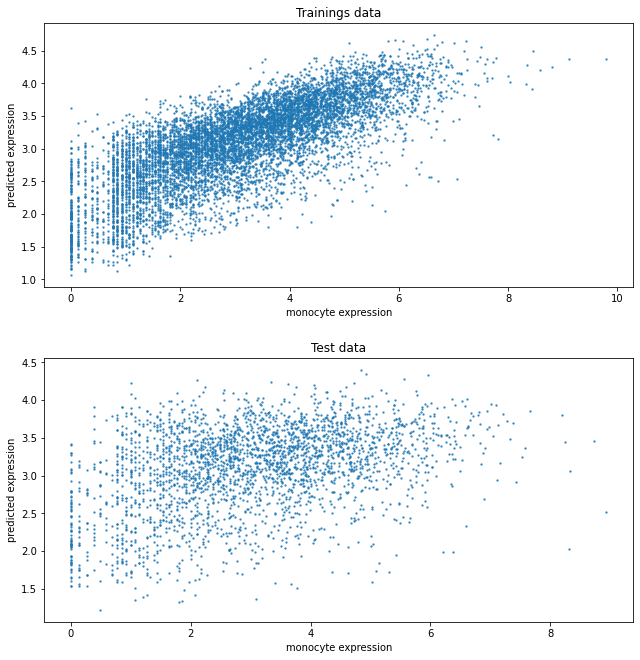

In [5]:
##plot real expression against predicted expression 

fig, axs = plt.subplots(2, figsize = (10,10))
fig.tight_layout(pad=5.0)
axs[0].set_xlabel("monocyte expression")
axs[0].set_ylabel("predicted expression")
axs[1].set_xlabel("monocyte expression")
axs[1].set_ylabel("predicted expression")
axs[0].scatter(train_new.loc[:,'monocytes'], train_new.loc[:,'predicted'], s = 2, alpha = 0.7)
axs[0].set_title("Trainings data")
axs[1].scatter(test_new.loc[:,'monocytes'], test_new.loc[:,'predicted'], s = 2, alpha = 0.7)
axs[1].set_title("Test data")


In [6]:
##print correlation
print("IH01 training set: \n", train_new[['monocytes', 'predicted']].corr())
print("IH01 test set: \n", test_new[['monocytes', 'predicted']].corr())

IH01 training set: 
            monocytes  predicted
monocytes   1.000000   0.747442
predicted   0.747442   1.000000
IH01 test set: 
            monocytes  predicted
monocytes   1.000000   0.382978
predicted   0.382978   1.000000


In [7]:
from sklearn import metrics

##score rf model

display('Trainings score: ', rf.score(train_new.drop(["monocytes","predicted"], axis = 1), train_new.loc[:,'monocytes']))
display('Trainings RMSE: ', metrics.mean_squared_error(train_new.loc[:,'monocytes'], train_new.loc[:,'predicted']))
display('Test score: ', rf.score(test_new.drop(["monocytes","predicted"], axis = 1), test_new.loc[:,'monocytes']))
display('Test RMSE: ',metrics.mean_squared_error(test_new.loc[:,'monocytes'], test_new.loc[:,'predicted']))


'Trainings score: '

0.44172796276425663

'Trainings RMSE: '

1.4017494145812166

'Test score: '

0.14449033595900218

'Test RMSE: '

2.1571956050427294

## Feature importances 

In [8]:
# get feature importances
importance = rf.feature_importances_
imp_features = pd.DataFrame(columns = ['feature', 'importance'])


# summarize feature importances
for i,v in enumerate(importance):
    imp_features.loc[i,:] = [train.columns[i],v]

imp_features.sort_values(by = 'importance', ascending = False)

,feature,importance
23,mean_cov_2k,0.050011
22,variance_cov_2k,0.046471
2,199,0.042083
1,202,0.040924
16,mean_cov_body1kb,0.036101
0,205,0.034436
34,amp1,0.033469
3,196,0.03343
35,amp2,0.031611
9,180,0.030927


## Test model on other samples

In [9]:
##predict expression of a cancer sample (IC17)

features_IC17.loc[:,'predicted'] = rf.predict(np.array(features_IC17.drop(["monocytes"], axis = 1)))

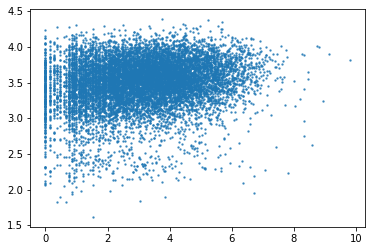

In [10]:
##plot real expression against predicted expression
plt.scatter(features_IC17.loc[:,'monocytes'], features_IC17.loc[:,'predicted'], s = 2, alpha = 0.7)

In [11]:
##print correlation 
features_IC17[['monocytes', 'predicted']].corr()

,monocytes,predicted
monocytes,1.000000,0.181786
predicted,0.181786,1.000000


# Compare predictions 

## Differentially predicted (expressed) genes 

In [12]:
##dataframe for differentially expressed genes
de_genes = pd.DataFrame(index = features_IC17.index)
de_genes["diff"] = 0

In [13]:
features_IH01 = train_new.append(test_new)
features_IH01_ordered = features_IH01.loc[features_IC17.index,:]

In [14]:
##calculate differences in expression of IC17
for g in features_IC17.index: 
    de_genes.loc[g, "diff"] = max(features_IC17.loc[g,'predicted'] - features_IH01_ordered.loc[g,'predicted'], features_IH01_ordered.loc[g,'predicted'] - features_IC17.loc[g,'predicted'])
    

In [15]:
##get 500 most differentially expressed genes 
de_genes_top500 = de_genes.nlargest(500, columns = "diff")

### Save top 500 and background genes (GeneOrganizer, David) 

In [16]:
pd.DataFrame(index = de_genes_top500.index).to_csv("cfDNA-reanalysis_Graz/kristin/rf_model/IC17/de_genes500.csv") 
pd.DataFrame(index = de_genes.index).to_csv("cfDNA-reanalysis_Graz/kristin/rf_model/background_genes.csv") 

### GSEA 

In [17]:
import pybiomart as pbm 

##get biomart dataset 
dataset = pbm.Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')

In [18]:
##get gene name for each gene id in de_genes
names = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])
de_genes_top500 = de_genes_top500.merge(names, left_index = True, right_on = 'Gene stable ID')

In [23]:
import gseapy as gp 

##display gene sets
#names = gp.get_library_name()

In [27]:
##enrichment analysis of de_genes 
enr = gp.enrichr(gene_list= list(de_genes_top500['Gene name']),
                 gene_sets=['Cancer_Cell_Line_Encyclopedia','MSigDB_Oncogenic_Signatures'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='DE_genes',
                 outdir='cfDNA-reanalysis_Graz/kristin/rf_model/gsea/',
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [114]:
enr.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Cancer_Cell_Line_Encyclopedia,HS571T OVARY,17/222,0.000046,0.040720,0,0,3.312781,33.068473,SLC24A3;PDE1C;SUSD2;EBF2;SOD3;CYGB;PARD3B;LRRN...
1,Cancer_Cell_Line_Encyclopedia,HS172T URINARY TRACT,13/150,0.000104,0.045688,0,0,3.772823,34.611258,SPON2;RARRES2;TMEM176B;TACR1;SOD3;CYGB;DLL4;SA...
2,Cancer_Cell_Line_Encyclopedia,WM115 SKIN,15/201,0.000170,0.049853,0,0,3.211506,27.879506,FLT1;PDE1C;CPXM2;LGI4;SLC35F1;TMEM171;FRMD5;MC...
3,Cancer_Cell_Line_Encyclopedia,HS675T LARGE INTESTINE,13/169,0.000339,0.069048,0,0,3.310062,26.447227,SPON2;FLT1;RARRES2;TMEM176B;CYGB;PARD3B;SGCD;G...
4,Cancer_Cell_Line_Encyclopedia,COLO783 SKIN,12/150,0.000398,0.069048,0,0,3.450107,27.009930,GPR143;MC1R;FLT1;SGCD;RTN4RL1;ADAMTS17;ALX1;SL...
